# Workshop Exercise

Let us do some research now, with help of the [CMIP6 dataset](https://pcmdi.llnl.gov/CMIP6/).
I have setup some possible climate change models for you to use, you have to fill in your camel ID and think of a research question!

We like the sentence:
- To understand [environment issue] in [region] we will study te impact of [verb/noun] on [hydrological variable].

But feel free to come up with your own!

In [17]:
# Required dependencies
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import ewatercycle
import ewatercycle.models

from util_functions import *

In [4]:
# Copy your camel ID from previous Notebook
camel_id = "AF_1491830.0"

In [19]:
# defining path for catchment shape file
central_path = Path.home() / "projects/book/tutorials_examples/1_HBV_Caravan_ERA5/mijndata/1491830"
path_to_save = Path.home() / "my_data/workshop_zimbabwe"
path_to_save.mkdir(exist_ok=True, parents=True)
shape_file = central_path / (camel_id[:-2] + ".shp")
data_file_nc = central_path / (camel_id + ".nc")

my_data_nc = xr.open_dataset(data_file_nc, engine="netcdf4")

# defining destination path for ERA5 data
forcing_path_CMIP = path_to_save / "CMIP_forcing"
forcing_path_CMIP.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = path_to_save / "CMIP_HBV"
model_path_HBV.mkdir(exist_ok=True)

In [7]:
future_start_data = "2026-01-01"
future_end_data = "2099-12-31"

## Downloading the climate scenarios
CMIP datasets can be found [here](https://aims2.llnl.gov/nodes), sometimes their servers are unreachable.
CMIP has these climate scenarios based on carbon emmisions, go [here](https://climate-scenarios.canada.ca/?page=cmip6-overview-notes) to find out more!
Here I setup SSP1, 2 and 5:
- SSP1: Sustainability - Taking the green road (low challenges to mitigation and adaptation)
- SSP2: Middle of the road - (medium challenges to mitigation and adaptation)
- SSP5: Fossil-fueled development - Taking the highway (high challenges to mitigation, low challenges to adaptation)

Since we are saving it to their respective folder (so if you change them, keep track of the folders) we only have to run the data gathering **ONCE**.

In [27]:
# Option one: Generate CMIP data and save it
# ONLY RUN THIS ONCE
# DO this for every experiment!

# cmip_dataset =  {
#    'project': 'CMIP6',
#    'activity': 'ScenarioMIP',
#    'exp': 'ssp126',
#    'mip': 'day',
#    'dataset': 'MPI-ESM1-2-HR',
#    'ensemble': 'r1i1p1f1',
#    'institute': 'DKRZ',
#    'grid': 'gn'
# }

# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=future_start_data+"T00:00:00Z",
#    end_time=future_end_data+"T00:00:00Z",
#    shape=shape_file,
#    directory=forcing_path_CMIP / "SSP126",
# )

# cmip_dataset =  {
#    'project': 'CMIP6',
#    'activity': 'ScenarioMIP',
#    'exp': 'ssp245',
#    'mip': 'day',
#    'dataset': 'MPI-ESM1-2-HR',
#    'ensemble': 'r1i1p1f1',
#    'institute': 'DKRZ',
#    'grid': 'gn'
# }

# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=future_start_data+"T00:00:00Z",
#    end_time=future_end_data+"T00:00:00Z",
#    shape=shape_file,
#    directory=forcing_path_CMIP / "SSP245",
# )

# cmip_dataset =  {
#    'project': 'CMIP6',
#    'activity': 'ScenarioMIP',
#    'exp': 'ssp585',
#    'mip': 'day',
#    'dataset': 'MPI-ESM1-2-HR',
#    'ensemble': 'r1i1p1f1',
#    'institute': 'DKRZ',
#    'grid': 'gn'
# }

# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=future_start_data+"T00:00:00Z",
#    end_time=future_end_data+"T00:00:00Z",
#    shape=shape_file,
#    directory=forcing_path_CMIP / "SSP585",
# )

In [12]:
# Load SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

In [13]:
# Add your parameters here, dont change the FM below, keep it at 0.001
parameters_found = [
    10.0,    # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.1,   # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001     # FM - Snowmelt factor (not critical in Zimbabwe, can remain low)
]

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

## Setting up the models

I took this bit from our Bachelor student Ischa, so thank you very much!
We put the forcings in a list and then we will use that to look through the models we created, using the BMI implementation.

In [20]:
forcing_list = [SSP126, SSP245, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(
        parameters=parameters_found, 
        initial_storage=s_0,
        cfg_dir = model_path_HBV,
    )

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

In [28]:
SSP126_output = pd.Series(data=output[0], name="SSP126", index=years[0])
SSP245_output = pd.Series(data=output[1], name="SSP245", index=years[1])
SSP585_output = pd.Series(data=output[2], name="SSP585", index=years[2])

print(SSP126_output)

2026-01-02 12:00:00    0.050504
2026-01-03 12:00:00    0.050501
2026-01-04 12:00:00    0.050498
2026-01-05 12:00:00    0.050488
2026-01-06 12:00:00    0.050473
                         ...   
2099-12-27 12:00:00    2.421937
2099-12-28 12:00:00    2.371266
2099-12-29 12:00:00    2.302091
2099-12-30 12:00:00    2.095406
2099-12-31 12:00:00    1.900903
Name: SSP126, Length: 27027, dtype: float64

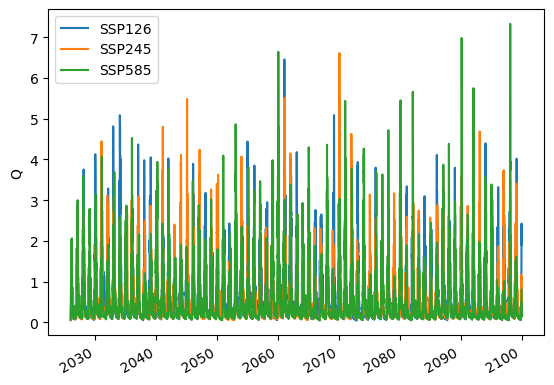

In [31]:
SSP126_output.plot()
SSP245_output.plot()
SSP585_output.plot()
plt.ylabel("Q (mm/d)")
plt.legend()

## Enter your research here!
I looked at the cumulative sum of the discharge as a simle example, up to you to implement your own!

In [25]:
cum_sum_126 = np.cumsum(SSP126_output)
cum_sum_245 = np.cumsum(SSP245_output)
cum_sum_585 = np.cumsum(SSP585_output)

[]

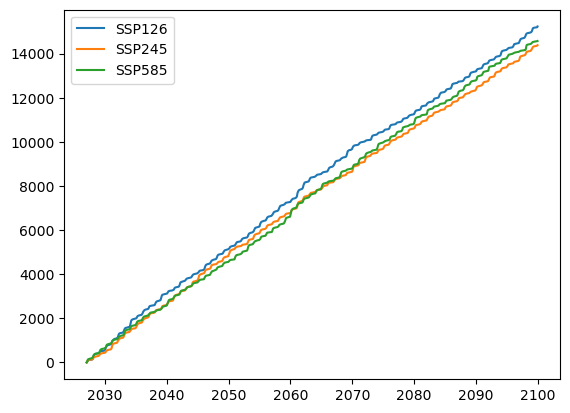

In [26]:
plt.plot(cum_sum_126, label="SSP126")
plt.plot(cum_sum_245, label="SSP245")
plt.plot(cum_sum_585, label="SSP585")
plt.legend()
plt.plot()